In [ ]:
#@title Mount my Drive
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
#@title Unzip the dataset
#uzipping the dataset into the directory
!unzip -q "/content/drive/My Drive/Collab Works/face_segmentation/dataset.zip"

In [ ]:
#@title install libraries
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.15
!pip install keras==2.3.1
!pip install pandas

In [ ]:
#inspect the dataset
import os
import cv2
image_paths = []
label_paths = []
for folder in os.listdir("dataset"):
  if os.path.isdir("dataset/"+folder) and folder != "labels" :
     folder_initial = folder.split("_")[0]
     for imagename in os.listdir("dataset/"+folder):
       if folder_initial == "male06":
         folder_initial = "male06_1"
       image_path = "dataset/"+folder+"/"+imagename
       label_path = "dataset/labels/"+folder_initial+"/"+imagename
       image_paths.append(image_path)
       label_paths.append(label_path)
      






In [ ]:
"""RED VALUE 	GREEN VALUE 	BLUE VALUE 	FACIAL LABEL
0 	0 	0 	Background/undefined
255 	0 	0 	Nose
0 	255 	0 	Eyes
0 	0 	255 	Lips
255 	255 	0 	Ears (Yellow)
0 	255 	255 	Hair
255 	0 	255 	Eyebrows
255 	255 	255 	Teeth
128 	128 	128 	General face
255 	192 	192 	Facial hair
0 	128 	128 	Specs/sunglasses



But we are merging certain classes:
"nose and face and facial hair and specs/sunglasses"
Face  = class0
Hair = class1
Background = class2

"""


In [ ]:
import numpy as np
def get_face_mask(label):
  d = np.where(label == [128,128,128] , 1 , 0)
  d = np.sum(d,axis=-1)/3
  d = np.where(d == 1, 1, 0)
  e = np.where(label == [255 ,	0 ,	0] , 1 , 0)
  e = np.sum(e,axis=-1)/3
  e = np.where(e == 1, 1, 0)
  f = np.where(label == [255 ,192,192] , 1 , 0)
  f = np.sum(f,axis=-1)/3
  f = np.where(f == 1, 1, 0)
  g = np.where(label == [0,128,128] , 1 , 0)
  g = np.sum(g,axis=-1)/3
  g = np.where(g == 1, 1, 0)

  k = d+e+f+g
  return k

#index = 1007
#d = get_face_mask(labels[index])


def get_hair_mask(label):
  d = np.where(label == [0,255,255] , 1 , 0)
  d = np.sum(d,axis=-1)/3
  d = np.where(d == 1, 1, 0)
  return d


def get_background_mask(face_mask, hair_mask):
  mask = face_mask + hair_mask
  new_mask = 1 - mask
  return new_mask

def get_segmentation_map(label):
  fm = get_face_mask(label)
  hm = get_hair_mask(label)
  d = get_background_mask(fm, hm)  
  map = np.stack([fm,hm, d], axis=-1)
  return map


#index = -10


#map = get_segmentation_map(labels[index])
#plt.imshow(map[:,:,2])
#map.shape

In [ ]:
#here we define a generator
from sklearn.utils import shuffle
import numpy as np
import cv2

class YugsGenerator:
    
    def __init__(self, image_paths, label_paths, batch_size,shuffle_dataset=True):
        if shuffle_dataset:
            self.image_paths, self.label_paths = shuffle(image_paths, label_paths,random_state=2)
        else:
            self.image_paths, self.label_paths = image_paths, label_paths
        self.batch_size = batch_size
        self.m = len(self.image_paths)
        
    def process(self, batch_image_paths, batch_label_paths):
        # takes a batch of image and label paths and converts them to images
        X = []; y = []
        for i in range(len(batch_image_paths)):
            image_path = batch_image_paths[i]; label_path = batch_label_paths[i]
            image = cv2.imread(image_path); label = cv2.imread(label_path) # shapes are 280,300
            try:
              image = cv2.resize(image, (300, 300))
              label = cv2.resize(label, (300, 300))
            except:
              continue
            map = get_segmentation_map(label) # shape 280,300,3
            X.append(image); y.append(map)
        return X, y
    
    def get_generator(self):
        index = 0
        while True:
            batch_image_paths = []; batch_label_paths = []
            if index+self.batch_size > self.m:
                batch_image_paths.extend(self.image_paths[index:self.m]); batch_image_paths.extend(self.image_paths[0:index+self.batch_size-self.m])
                batch_label_paths.extend(self.label_paths[index:self.m]); batch_label_paths.extend(self.label_paths[0:index+self.batch_size-self.m])
                index = index+self.batch_size-self.m
            else:
                batch_image_paths = self.image_paths[index : index+self.batch_size]
                batch_label_paths = self.label_paths[index : index+self.batch_size]
                index += self.batch_size
            X, y = self.process(batch_image_paths, batch_label_paths)
            X = np.array(X)/255.0
            y = np.array(y)
            yield X, y





In [ ]:
from keras.layers import Cropping2D,Input, Conv2D, BatchNormalization, MaxPooling2D, Conv2DTranspose, Dropout,Activation,Concatenate
from keras.models import Model

dropout = 0.2;n_filters = 16

def convolutional_block(inpt, n_filters, kernel_size = 3):
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(inpt)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters = n_filters, kernel_size = (kernel_size, kernel_size),kernel_initializer = 'he_normal', padding = 'same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    return x
  
input_img = Input(shape=(300,300,3))
c1 = convolutional_block(input_img, n_filters * 1, kernel_size = 3)
p1 = MaxPooling2D((2, 2))(c1)
p1 = Dropout(dropout)(p1)
c2 = convolutional_block(p1, n_filters * 2, kernel_size = 3)
p2 = MaxPooling2D((2, 2))(c2)
p2 = Dropout(dropout)(p2)
c3 = convolutional_block(p2, n_filters * 4, kernel_size = 3)
p3 = MaxPooling2D((2, 2))(c3)
p3 = Dropout(dropout)(p3)
c4 = convolutional_block(p3, n_filters * 8, kernel_size = 3)
p4 = MaxPooling2D((2, 2))(c4)
p4 = Dropout(dropout)(p4)
c5 = convolutional_block(p4, n_filters = n_filters * 16, kernel_size = 3)
u6 = Conv2DTranspose(n_filters * 8, (3,3), strides = (2,2))(c5)
u6 = Concatenate()([u6, c4])
u6 = Dropout(dropout)(u6)
c6 = convolutional_block(u6, n_filters * 8, kernel_size = 3)
u7 = Conv2DTranspose(n_filters * 4, (3, 3), strides = (2, 2))(c6)
u7 = Concatenate()([u7, c3])
u7 = Dropout(dropout)(u7)
c7 = convolutional_block(u7, n_filters * 4, kernel_size = 3)
u8 = Conv2DTranspose(n_filters * 2, (3, 3), strides = (2, 2),padding="same")(c7)
u8 = Concatenate()([u8, c2])
u8 = Dropout(dropout)(u8)
c8 = convolutional_block(u8, n_filters * 2, kernel_size = 3)
u9 = Conv2DTranspose(n_filters * 1, (3, 3), strides = (2, 2), padding="same")(c8)
u9 = Concatenate()([u9, c1])
u9 = Dropout(dropout)(u9)
c9 = convolutional_block(u9, n_filters * 1, kernel_size = 3)
outputs = Conv2D(3, (1, 1), activation='softmax')(c9)
model = Model(inputs=[input_img], outputs=[outputs])


In [ ]:
model.compile(loss='categorical_crossentropy',
                      optimizer='adam',
                      metrics=['accuracy'])

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

image_paths, label_paths = shuffle(image_paths, label_paths,random_state=2)


X_train, X_test, y_train, y_test = train_test_split(image_paths, label_paths, test_size=0.2)


g = YugsGenerator(X_train, y_train, batch_size=32,shuffle_dataset=True)
train_gen = g.get_generator()



g = YugsGenerator(X_test, y_test, batch_size=32,shuffle_dataset=True)
test_gen = g.get_generator()


In [ ]:
model.fit_generator(train_gen  , validation_data=test_gen, steps_per_epoch = len(X_train) //32 , epochs=20, validation_steps=len(X_test)//32)

Epoch 1/20
413/413 [==============================] - 604s 1s/step - loss: 0.4801 - accuracy: 0.8156 - val_loss: 0.7300 - val_accuracy: 0.7451
Epoch 2/20
413/413 [==============================] - 580s 1s/step - loss: 0.2925 - accuracy: 0.8884 - val_loss: 0.3637 - val_accuracy: 0.8929
Epoch 3/20
413/413 [==============================] - 572s 1s/step - loss: 0.2231 - accuracy: 0.9156 - val_loss: 0.2729 - val_accuracy: 0.9182
Epoch 4/20
413/413 [==============================] - 572s 1s/step - loss: 0.1845 - accuracy: 0.9306 - val_loss: 0.2368 - val_accuracy: 0.9372
Epoch 5/20
413/413 [==============================] - 574s 1s/step - loss: 0.1608 - accuracy: 0.9394 - val_loss: 0.1985 - val_accuracy: 0.9362
Epoch 6/20
Epoch 6/20
413/413 [==============================] - 574s 1s/step - loss: 0.1443 - accuracy: 0.9459 - val_loss: 0.1599 - val_accuracy: 0.9445
Epoch 7/20
Epoch 7/20
413/413 [==============================] - 572s 1s/step - loss: 0.1375 - accuracy: 0.9484 - val_loss: 0.1346 

KeyboardInterrupt: ignored

KeyboardInterrupt: ignored

In [ ]:
# saving the model
model.save("/content/drive/My Drive/Collab Works/face_segmentation/face_segmentation_model.h5")

In [ ]:
image = cv2.resize(cv2.imread("test_6.jpg"), (300,300))
prediction = model.predict(image.reshape(1,300,300,3)/255.0)




In [ ]:
np.argmax(prediction[0], axis=-1)

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2]])

In [ ]:
def get_label_from_prediction(pred):
  # should return a 3d segmentation label
  pass

(300, 300, 3)

In [ ]:
import matplotlib.pyplot as plt

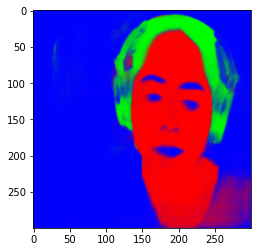

In [ ]:
plt.imshow(prediction[0])

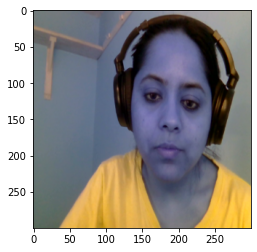

In [ ]:
plt.imshow(image)